# Benchmark similarity checks

Remember to compile `cnnclustering` with `TRACE_CYTHON=0` if timings should be measured. `TRACE_CYTHON=1` is required for line profiling and test coverage and will cause substantial overhead.

Notebook to organise benchmarks of different implementations of the density-criterion (similarity) check. In general, two neighbourhood containers are tested to have at least a certain number of common elements.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requirements" data-toc-modified-id="Pre-requirements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requirements</a></span></li><li><span><a href="#Version-info" data-toc-modified-id="Version-info-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Version info</a></span></li><li><span><a href="#Helper-function-definitions" data-toc-modified-id="Helper-function-definitions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Helper function definitions</a></span><ul class="toc-item"><li><span><a href="#Plots" data-toc-modified-id="Plots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plots</a></span></li></ul></li><li><span><a href="#Runs" data-toc-modified-id="Runs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Runs</a></span><ul class="toc-item"><li><span><a href="#CommonNN-similarity-check" data-toc-modified-id="CommonNN-similarity-check-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CommonNN similarity check</a></span><ul class="toc-item"><li><span><a href="#Run-a-a" data-toc-modified-id="Run-a-a-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Run a a</a></span></li><li><span><a href="#Run-a-b" data-toc-modified-id="Run-a-b-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Run a b</a></span></li><li><span><a href="#Run-a-c" data-toc-modified-id="Run-a-c-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Run a c</a></span></li><li><span><a href="#Run-b-a" data-toc-modified-id="Run-b-a-4.1.4"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>Run b a</a></span></li><li><span><a href="#Run-b-b" data-toc-modified-id="Run-b-b-4.1.5"><span class="toc-item-num">4.1.5&nbsp;&nbsp;</span>Run b b</a></span></li><li><span><a href="#Run-b-c" data-toc-modified-id="Run-b-c-4.1.6"><span class="toc-item-num">4.1.6&nbsp;&nbsp;</span>Run b c</a></span></li><li><span><a href="#Run-c-a" data-toc-modified-id="Run-c-a-4.1.7"><span class="toc-item-num">4.1.7&nbsp;&nbsp;</span>Run c a</a></span></li><li><span><a href="#Run-c-b" data-toc-modified-id="Run-c-b-4.1.8"><span class="toc-item-num">4.1.8&nbsp;&nbsp;</span>Run c b</a></span></li></ul></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Scaling</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Run-a-a" data-toc-modified-id="Run-a-a-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Run a a</a></span></li><li><span><a href="#Run-a-b" data-toc-modified-id="Run-a-b-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Run a b</a></span></li><li><span><a href="#Run-a-c" data-toc-modified-id="Run-a-c-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Run a c</a></span></li><li><span><a href="#Run-b-a" data-toc-modified-id="Run-b-a-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Run b a</a></span></li><li><span><a href="#Compare-switch/no-switch" data-toc-modified-id="Compare-switch/no-switch-4.8"><span class="toc-item-num">4.8&nbsp;&nbsp;</span>Compare switch/no switch</a></span></li><li><span><a href="#Compare-worst-case" data-toc-modified-id="Compare-worst-case-4.9"><span class="toc-item-num">4.9&nbsp;&nbsp;</span>Compare worst case</a></span></li></ul></li></ul></div>

## Pre-requirements

In [1]:
from datetime import datetime

import cnnclustering
from cnnclustering import cluster
from cnnclustering import _fit, _primitive_types, _types
from IPython.core.magics.execution import TimeitResult
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

import helper

In [2]:
import importlib

In [3]:
importlib.reload(helper)

<module 'helper' from '/home/janjoswig/repo/CommonNNClustering/docsrc/benchmark/helper.py'>

In [4]:
mpl.rcParams["figure.dpi"] = 300

## Version info

In [5]:
print(f"{'Python':>20} :  ", *sys.version.splitlines())

modules = [
]

for alias, m in modules:
    try:
        print(f"{alias:>20} :  ", m.__version__)
    except AttributeError:
        print(f"{alias:>20} :  ", "no version info")

              Python :   3.8.8 (default, Mar 11 2021, 08:58:19)  [GCC 8.3.0]


In [6]:
print(f"cnnclustering :  ", cnnclustering.__version__)

cnnclustering :   0.4.2


## Helper function definitions

In [7]:
rng = np.random.default_rng(2021)

In [8]:
# Case generation
def gen_range(start, stop, step):
    yield from range(start, stop, step)
    
def gen_shuffled(start, stop, step):
    from_range = np.arange(start, stop, step)
    yield from rng.choice(from_range, size=((stop - start) // step), replace=False)

In [9]:
member_counts = [200 * 5**x for x in range(6)]
member_counts

[200, 1000, 5000, 25000, 125000, 625000]

In [10]:
CASES_MAP = {}

case_name = "equal_c50"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_range, (0, count, 1), gen_range, (0, count, 1), count // 2)
        )
    
case_name = "mixed_c50"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_shuffled, (0, count, 1), gen_shuffled, (0, count, 2), count // 4)
        )
    
case_name = "shuffled_c50"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_shuffled, (0, count, 1), gen_shuffled, (0, count, 1), count // 2)
        )
    
case_name = "mixed_shuffled_c50"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_shuffled, (0, count, 1), gen_shuffled, (0, count, 2), count // 4)
        )
    
case_name = "equal_c33"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_range, (0, count, 1), gen_range, (0, count, 1), count // 3)
        )

case_name = "mixed_c33"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_shuffled, (0, count, 1), gen_shuffled, (0, count, 2), count // 6)
        )

case_name = "shuffled_c33"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_shuffled, (0, count, 1), gen_shuffled, (0, count, 1), count // 3)
        )
    
case_name = "mixed_shuffled_c33"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_shuffled, (0, count, 1), gen_shuffled, (0, count, 2), count // 6)
        )
    
case_name = "no_check"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_range, (0, count, 1), gen_range, (0, count, 1), 0)
        )
    
case_name = "diff"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_range, (0, count, 1), gen_range, (count, 2*count, 1), 1)
        )
    
case_name = "equal_p625000"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_range, (0, 625000, 1), gen_range, (0, 625000, 1), count)
        )

In [11]:
CASES_MAP

{'equal_c50': [('200',
   <function __main__.gen_range(start, stop, step)>,
   (0, 200, 1),
   <function __main__.gen_range(start, stop, step)>,
   (0, 200, 1),
   100),
  ('1000',
   <function __main__.gen_range(start, stop, step)>,
   (0, 1000, 1),
   <function __main__.gen_range(start, stop, step)>,
   (0, 1000, 1),
   500),
  ('5000',
   <function __main__.gen_range(start, stop, step)>,
   (0, 5000, 1),
   <function __main__.gen_range(start, stop, step)>,
   (0, 5000, 1),
   2500),
  ('25000',
   <function __main__.gen_range(start, stop, step)>,
   (0, 25000, 1),
   <function __main__.gen_range(start, stop, step)>,
   (0, 25000, 1),
   12500),
  ('125000',
   <function __main__.gen_range(start, stop, step)>,
   (0, 125000, 1),
   <function __main__.gen_range(start, stop, step)>,
   (0, 125000, 1),
   62500),
  ('625000',
   <function __main__.gen_range(start, stop, step)>,
   (0, 625000, 1),
   <function __main__.gen_range(start, stop, step)>,
   (0, 625000, 1),
   312500)],
 'mixe

In [12]:
def collect_timings(
        checker, na, nb,
        cases, timings=None):
    """Orchestrate timings
    
    Args:
        
        
    Keyword args:
        timings: An optional timings mapping which results should be
            put into.
    
    Returns:
        timings mapping
    """
    
    # Timed function has to be in global namespace to be discovered by %timeit magic
    global timed_args
    global timed_kwargs
    global timed_func
    
    if timings is None:
        timings = {}
    
    progress = tqdm(cases, desc="Run completed")
    
    for run_index, (run_id, gen_a, args_a, gen_b, args_b, c) in enumerate(progress):
        
        na.reset()
        for index in gen_a(*args_a):
            na.assign(index)

        nb.reset()
        for index in gen_b(*args_b):
            nb.assign(index)
        
        cluster_params = _types.ClusterParameters(0, c)
        
        timings[run_id] = %timeit -q -o checker.check(na, nb, cluster_params)
        
        tqdm.write(f"Timed run ID: {run_id:>10}    ({datetime.now().strftime('%d.%m.%Y %H:%M:%S')})")
        
    return timings

### Plots

In [13]:
def evaluate_timings(
        RUN_TIMINGS_MAP, RUN_SCALING_MAP, run_name_list,
        normal_ax=None, log_ax=None,
        plot_props=None, legend_props=None):
    
    if (normal_ax is None) & (log_ax is None):
        fig, (normal_ax, log_ax) = plt.subplots(2, 1)
    elif normal_ax is not None:
        fig = normal_ax.get_figure()
    else:
        fig = log_ax.get_figure()
        
    if plot_props is None:
        plot_props = {}

    default_legend_props = {
        "fancybox": False,
        "framealpha": 1,
        "edgecolor": "k",
        "fontsize": "xx-small",    
        }
        
    if legend_props is not None:
        default_legend_props.update(legend_props)
        
    fit_lines = []
    fit_legend_labels = []
    
    normal_lines = []
    log_lines = []
    
    for name, label in run_name_list:

        (newx, fity), b = RUN_SCALING_MAP[name]
        
        if normal_ax is not None:
            n_line, = helper.plot_timings(
                RUN_TIMINGS_MAP[name],
                ax=normal_ax,
                id_to_x=lambda x: int(x),
                sort_ids=True,
                set_ax_props=False,
                plot_props=plot_props
            )
            normal_lines.append(n_line)
            f_line, = normal_ax.plot(
                newx, fity,
                linestyle="--",
                color=n_line.get_color(),
                marker="None",
                zorder=0
            )
            fit_legend_labels.append(f'{label} ($b = {b[0]:.1f} \pm {b[1]:.1f}$)')
            fit_lines.append(f_line)
    
        if log_ax is not None:
            l_line, = helper.plot_timings(
                RUN_TIMINGS_MAP[name],
                ax=log_ax,
                id_to_x=lambda x: int(x),
                sort_ids=True,
                set_ax_props=False,
                plot_props=plot_props
            )
            log_lines.append(l_line)
            fl_line, = log_ax.plot(
                newx, fity,
                linestyle="--",
                color=l_line.get_color(),
                marker="None",
                zorder=0
            )
            
            if normal_ax is None:
                fit_legend_labels.append(f'{label} ($b = {b[0]:.1f} \pm {b[1]:.1f}$)')
                fit_lines.append(fl_line)
        
    if normal_ax is not None:
        normal_ax.set(**{
            "xlabel": None,
            "ylabel": None,
            "ylim": (0, None)
        })
            
        if log_ax is not None:
            normal_ax.xaxis.tick_top()

    if log_ax is not None:
        log_ax.set(**{
            "xlabel": None,
            "ylabel": None,
            "xscale": "log",
            "yscale": "log",
            "ylim": (1e-6, None)
        })

    if normal_ax is not None:
        legend_ax = normal_ax
        legend_lines = normal_lines
    else:
        legend_ax = log_ax
        legend_lines = log_lines

    legend = legend_ax.legend(
        legend_lines,
        fit_legend_labels,
        **default_legend_props
        )
    legend.get_frame().set_linewidth(0.5)
    
    return fig

In [14]:
marker_list = [
    "o", "v", "^", "s", "p", "P", "*", "h",
    "d", "H", "D", ">", "<", "8", "X", "o"

]
color_list = [
    '396ab1', 'da7c30', '3e9651', 'cc2529', '535154', '6b4c9a', '922428', '948b3d',
    '7293cb', 'e1974c', '84ba5b', 'd35e60', '9067a7', 'ab6857', 'ccc210', '808585'
]

## Runs

In [15]:
if "RUN_TIMINGS_MAP" not in dir():
    RUN_TIMINGS_MAP = {}

In [16]:
report_dir = pathlib.Path("reports/qcm07/cnnclustering_similarity_check")

In [17]:
case_list = CASES_MAP.keys()

run_list = [
    "run_a_a",
    "run_a_b",
    "run_a_c",
    "run_b_a",
    "run_b_c",
    "run_c_a",
    "run_c_b"
]

for run_name in run_list:
    for case_name in case_list:
        full_run_name = f"{case_name}_{run_name}"
        report_file = report_dir / f"{full_run_name}.json"
        try:
            RUN_TIMINGS_MAP[full_run_name] = helper.load_report(report_file)
        except FileNotFoundError:
            pass

### CommonNN similarity check

Checking of similarity criterion for fixed cases of neighbour lists:

  - SimilarityCheckerExtContains
    - NeighboursExtVector [run a_a](#run_a_a)
    - NeighboursExtCPPUnorderedSet [run a_b](#run_a_b)
    - NeighboursExtVectorCPPUnorderedSet [run a_c](#run_a_c)
  - SimilarityCheckerExtSwitchContains
    - NeighboursExtVector [run b_a](#run_b_a)
    - NeighboursExtCPPUnorderedSet [run b_b](#run_b_b)
    - NeighboursExtVectorCPPUnorderedSet [run b_c](#run_b_c)
  - SimilarityCheckerExtScreensorted
    - NeighboursExtVector [run c_a](#run_c_a)
    - NeighboursExtVectorCPPUnorderedSet [run c_b](#run_c_b)

<a id="run_a_a"></a>
#### Run a a

In [18]:
case_list = CASES_MAP.keys()
case_list

dict_keys(['equal_c50', 'mixed_c50', 'shuffled_c50', 'mixed_shuffled_c50', 'equal_c33', 'mixed_c33', 'shuffled_c33', 'mixed_shuffled_c33', 'no_check', 'diff', 'equal_p625000'])

In [18]:
case_list = [
    # 'equal_c50',
    # 'mixed_c50',
    # 'shuffled_c50',
    # 'mixed_shuffled_c50',
    # 'equal_c33',
    # 'mixed_c33',
    # 'shuffled_c33',
    # 'mixed_shuffled_c33',
    # 'no_check',
    'diff',
    'equal_p625000'
]

In [19]:
checker = _types.SimilarityCheckerExtContains()
na = _types.NeighboursExtVector(1)
nb = _types.NeighboursExtVector(1)

In [ ]:
run_name = "run_a_a"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

Collection for run: diff_run_a_a


Run completed:   0%|          | 0/6 [00:00<?, ?it/s]

Timed run ID:        200    (18.06.2021 21:56:20)
Timed run ID:       1000    (18.06.2021 21:56:22)


<a id="run_a_b"></a>
#### Run a b

In [ ]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'shuffled_c50',
    'mixed_shuffled_c50',
    'equal_c33',
    'mixed_c33',
    'shuffled_c33',
    'mixed_shuffled_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [ ]:
checker = _types.SimilarityCheckerExtContains()
na = _types.NeighboursExtCPPUnorderedSet()
nb = _types.NeighboursExtCPPUnorderedSet()

In [ ]:
run_name = "run_a_b"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

<a id="run_a_c"></a>
#### Run a c

In [ ]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'shuffled_c50',
    'mixed_shuffled_c50',
    'equal_c33',
    'mixed_c33',
    'shuffled_c33',
    'mixed_shuffled_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [ ]:
checker = _types.SimilarityCheckerExtContains()
na = _types.NeighboursExtVectorCPPUnorderedSet(1)
nb = _types.NeighboursExtVectorCPPUnorderedSet(1)

In [ ]:
run_name = "run_a_c"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

<a id="run_b_a"></a>
#### Run b a

In [ ]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'shuffled_c50',
    'mixed_shuffled_c50',
    'equal_c33',
    'mixed_c33',
    'shuffled_c33',
    'mixed_shuffled_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [ ]:
checker = _types.SimilarityCheckerExtSwitchContains()
na = _types.NeighboursExtVector(1)
nb = _types.NeighboursExtVector(1)

In [ ]:
run_name = "run_b_a"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

<a id="run_b_b"></a>
#### Run b b

In [ ]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'shuffled_c50',
    'mixed_shuffled_c50',
    'equal_c33',
    'mixed_c33',
    'shuffled_c33',
    'mixed_shuffled_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [ ]:
checker = _types.SimilarityCheckerExtSwitchContains()
na = _types.NeighboursExtCPPUnorderedSet()
nb = _types.NeighboursExtCPPUnorderedSet()

In [ ]:
run_name = "run_b_b"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

<a id="run_b_c"></a>
#### Run b c

In [ ]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'shuffled_c50',
    'mixed_shuffled_c50',
    'equal_c33',
    'mixed_c33',
    'shuffled_c33',
    'mixed_shuffled_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [ ]:
checker = _types.SimilarityCheckerExtSwitchContains()
na = _types.NeighboursExtVectorCPPUnorderedSet(1)
nb = _types.NeighboursExtVectorCPPUnorderedSet(1)

In [ ]:
run_name = "run_b_c"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

<a id="run_c_a"></a>
#### Run c a

In [18]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'equal_c33',
    'mixed_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [19]:
checker = _types.SimilarityCheckerExtScreensorted()
na = _types.NeighboursExtVector(1)
nb = _types.NeighboursExtVector(1)

In [20]:
run_name = "run_c_a"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

Collection for run: equal_c50_run_c_a


Run completed:   0%|          | 0/6 [00:00<?, ?it/s]

Timed run ID:        200    (21.06.2021 21:28:48)
Timed run ID:       1000    (21.06.2021 21:28:51)
Timed run ID:       5000    (21.06.2021 21:28:55)
Timed run ID:      25000    (21.06.2021 21:29:08)
Timed run ID:     125000    (21.06.2021 21:29:13)
Timed run ID:     625000    (21.06.2021 21:29:16)
    Run ID: Factor
       200: 1.00
      1000: 1.16
      5000: 1.99
     25000: 6.30
    125000: 26.35
    625000: 128.20

Collection for run: mixed_c50_run_c_a


Run completed:   0%|          | 0/6 [00:00<?, ?it/s]

Timed run ID:        200    (21.06.2021 21:29:18)
Timed run ID:       1000    (21.06.2021 21:29:20)
Timed run ID:       5000    (21.06.2021 21:29:24)
Timed run ID:      25000    (21.06.2021 21:29:36)
Timed run ID:     125000    (21.06.2021 21:29:40)
Timed run ID:     625000    (21.06.2021 21:29:42)
    Run ID: Factor
       200: 1.00
      1000: 1.17
      5000: 2.06
     25000: 5.72
    125000: 22.13
    625000: 91.25

Collection for run: equal_c33_run_c_a


Run completed:   0%|          | 0/6 [00:00<?, ?it/s]

Timed run ID:        200    (21.06.2021 21:29:45)
Timed run ID:       1000    (21.06.2021 21:29:47)
Timed run ID:       5000    (21.06.2021 21:29:50)
Timed run ID:      25000    (21.06.2021 21:29:59)
Timed run ID:     125000    (21.06.2021 21:30:03)
Timed run ID:     625000    (21.06.2021 21:30:05)
    Run ID: Factor
       200: 1.00
      1000: 1.11
      5000: 1.68
     25000: 4.65
    125000: 18.90
    625000: 87.43

Collection for run: mixed_c33_run_c_a


Run completed:   0%|          | 0/6 [00:00<?, ?it/s]

Timed run ID:        200    (21.06.2021 21:30:07)
Timed run ID:       1000    (21.06.2021 21:30:10)
Timed run ID:       5000    (21.06.2021 21:30:14)
Timed run ID:      25000    (21.06.2021 21:30:16)
Timed run ID:     125000    (21.06.2021 21:30:23)
Timed run ID:     625000    (21.06.2021 21:30:25)
    Run ID: Factor
       200: 1.00
      1000: 1.21
      5000: 2.21
     25000: 9.27
    125000: 33.80
    625000: 125.21

Collection for run: no_check_run_c_a


Run completed:   0%|          | 0/6 [00:00<?, ?it/s]

Timed run ID:        200    (21.06.2021 21:30:27)
Timed run ID:       1000    (21.06.2021 21:30:29)
Timed run ID:       5000    (21.06.2021 21:30:31)
Timed run ID:      25000    (21.06.2021 21:30:33)
Timed run ID:     125000    (21.06.2021 21:30:35)
Timed run ID:     625000    (21.06.2021 21:30:37)
    Run ID: Factor
       200: 1.00
      1000: 1.00
    625000: 1.00
    125000: 1.00
      5000: 1.00
     25000: 1.01

Collection for run: diff_run_c_a


Run completed:   0%|          | 0/6 [00:00<?, ?it/s]

Timed run ID:        200    (21.06.2021 21:30:39)
Timed run ID:       1000    (21.06.2021 21:30:41)
Timed run ID:       5000    (21.06.2021 21:30:45)
Timed run ID:      25000    (21.06.2021 21:30:59)
Timed run ID:     125000    (21.06.2021 21:31:05)
Timed run ID:     625000    (21.06.2021 21:31:07)
    Run ID: Factor
       200: 1.00
      1000: 1.15
      5000: 1.97
     25000: 6.73
    125000: 26.58
    625000: 123.95

Collection for run: equal_p625000_run_c_a


Run completed:   0%|          | 0/6 [00:00<?, ?it/s]

Timed run ID:        200    (21.06.2021 21:31:10)
Timed run ID:       1000    (21.06.2021 21:31:12)
Timed run ID:       5000    (21.06.2021 21:31:19)
Timed run ID:      25000    (21.06.2021 21:31:21)
Timed run ID:     125000    (21.06.2021 21:31:32)
Timed run ID:     625000    (21.06.2021 21:31:37)
    Run ID: Factor
       200: 1.00
      1000: 1.34
      5000: 2.89
     25000: 11.25
    125000: 50.06
    625000: 247.90



<a id="run_c_b"></a>
#### Run c b

In [30]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'equal_c33',
    'mixed_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [31]:
checker = _types.SimilarityCheckerExtScreensorted()
na = _types.NeighboursExtVectorCPPUnorderedSet(1)
nb = _types.NeighboursExtVectorCPPUnorderedSet(1)

In [ ]:
run_name = "run_c_b"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

Collection for run: equal_c50_run_c_b


Run completed:   0%|          | 0/6 [00:00<?, ?it/s]

Timed run ID:        200    (21.06.2021 21:33:48)
Timed run ID:       1000    (21.06.2021 21:33:51)
Timed run ID:       5000    (21.06.2021 21:33:56)
Timed run ID:      25000    (21.06.2021 21:34:10)


In [ ]:
RUN_TIMINGS_MAP.keys()

### Scaling

Fit for empirical growth function:

$ t = a n^b + c$

In [ ]:
def growth(n, a, b):
    return a * n**b

def growth_with_c(n, a, b, c):
    return a * n**b + c

def scale(x, y, newx, f=growth):
    
    try:
        popt, pcov = curve_fit(f, x, y, p0=(0.1, 1.5))
        perr = np.sqrt(np.diag(pcov))
    except RuntimeError as error:
        print(error)
    else:
        return growth(newx, *popt), (popt, perr)

In [ ]:
if "RUN_SCALING_MAP" not in dir():
    RUN_SCALING_MAP = {}

In [ ]:
for full_run_name, timings in RUN_TIMINGS_MAP.items():
    print(full_run_name)
    x, y = zip(*((int(k), v.best) for k, v in timings.items()))
    x = np.asarray(x)
    y = np.asarray(y)
    sorti = np.argsort(x)
    x = x[sorti]
    y = y[sorti]
    
    newx = np.linspace(x[0], x[-1], 100)
    fity, (popt, perr) = scale(x, y, newx)
    RUN_SCALING_MAP[full_run_name] = (newx, fity), (popt[1], perr[1])

### Plots

### Run a a

In [220]:
run_name_list = [
    (k, k.replace("_run_a_a", "").replace("_", " "))
    for k in RUN_TIMINGS_MAP.keys()
    if "run_a_a" in k
]

Text(0, 0.5, 'time / s')

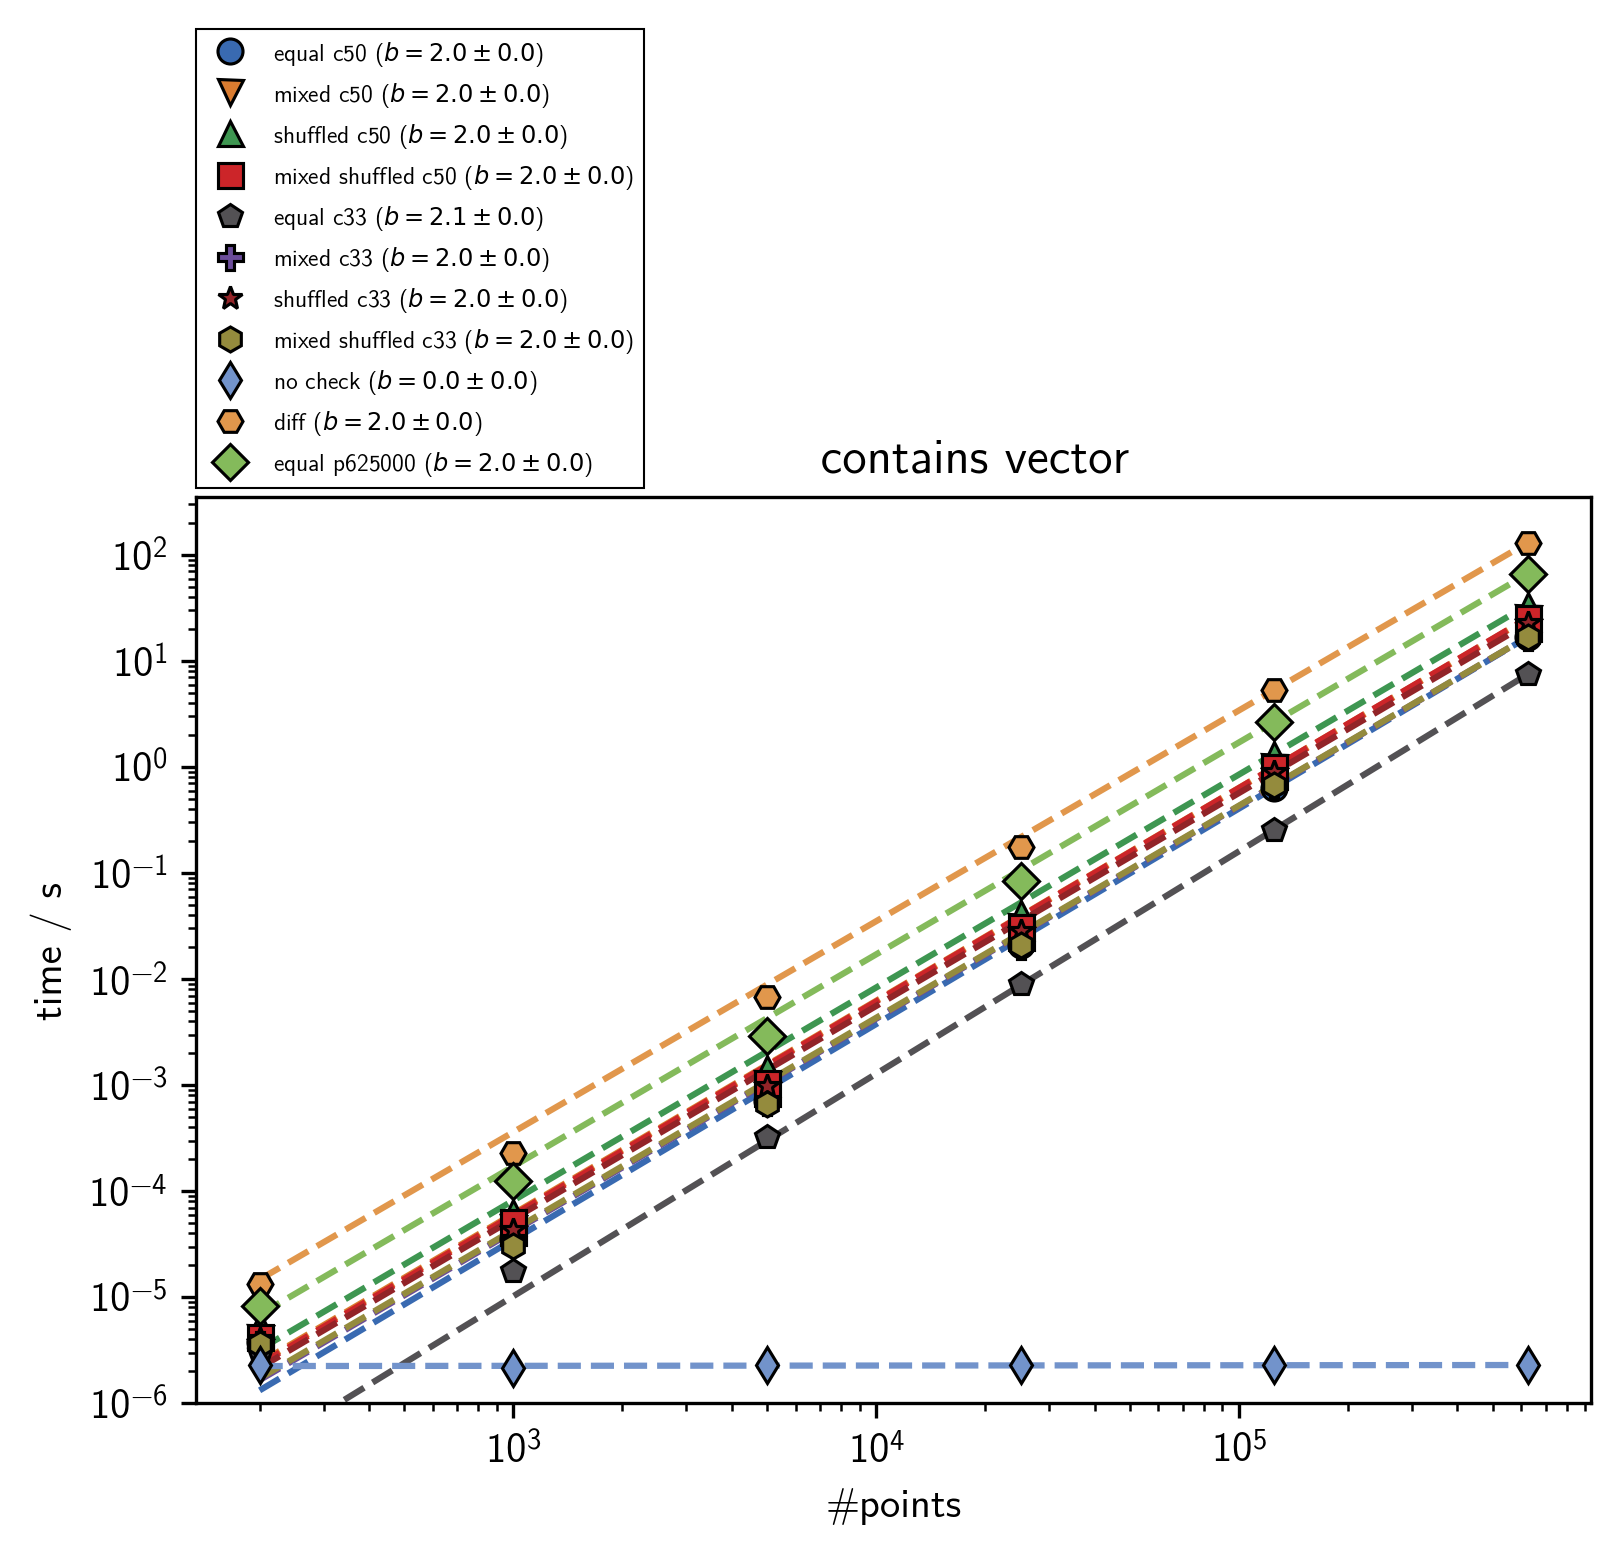

In [232]:
plt.close("all")
fig, log_ax = plt.subplots()
log_ax.set_prop_cycle(
    marker=marker_list,
    color=color_list,
)
_ = evaluate_timings(
    RUN_TIMINGS_MAP, RUN_SCALING_MAP, run_name_list,
    log_ax=log_ax,
    plot_props={
        "linestyle": "",
        "markeredgecolor": "k",
        "markeredgewidth": 0.75,
        },
    legend_props={
        "loc": (0, 1.01)
        }
    )

log_ax.set_title(" " * 10 + "Contains vector")
log_ax.set_xlabel("#points")
log_ax.set_ylabel("time / s")

### Run a b

In [234]:
run_name_list = [
    (k, k.replace("_run_a_b", "").replace("_", " "))
    for k in RUN_TIMINGS_MAP.keys()
    if "run_a_b" in k
]

Text(0, 0.5, 'time / s')

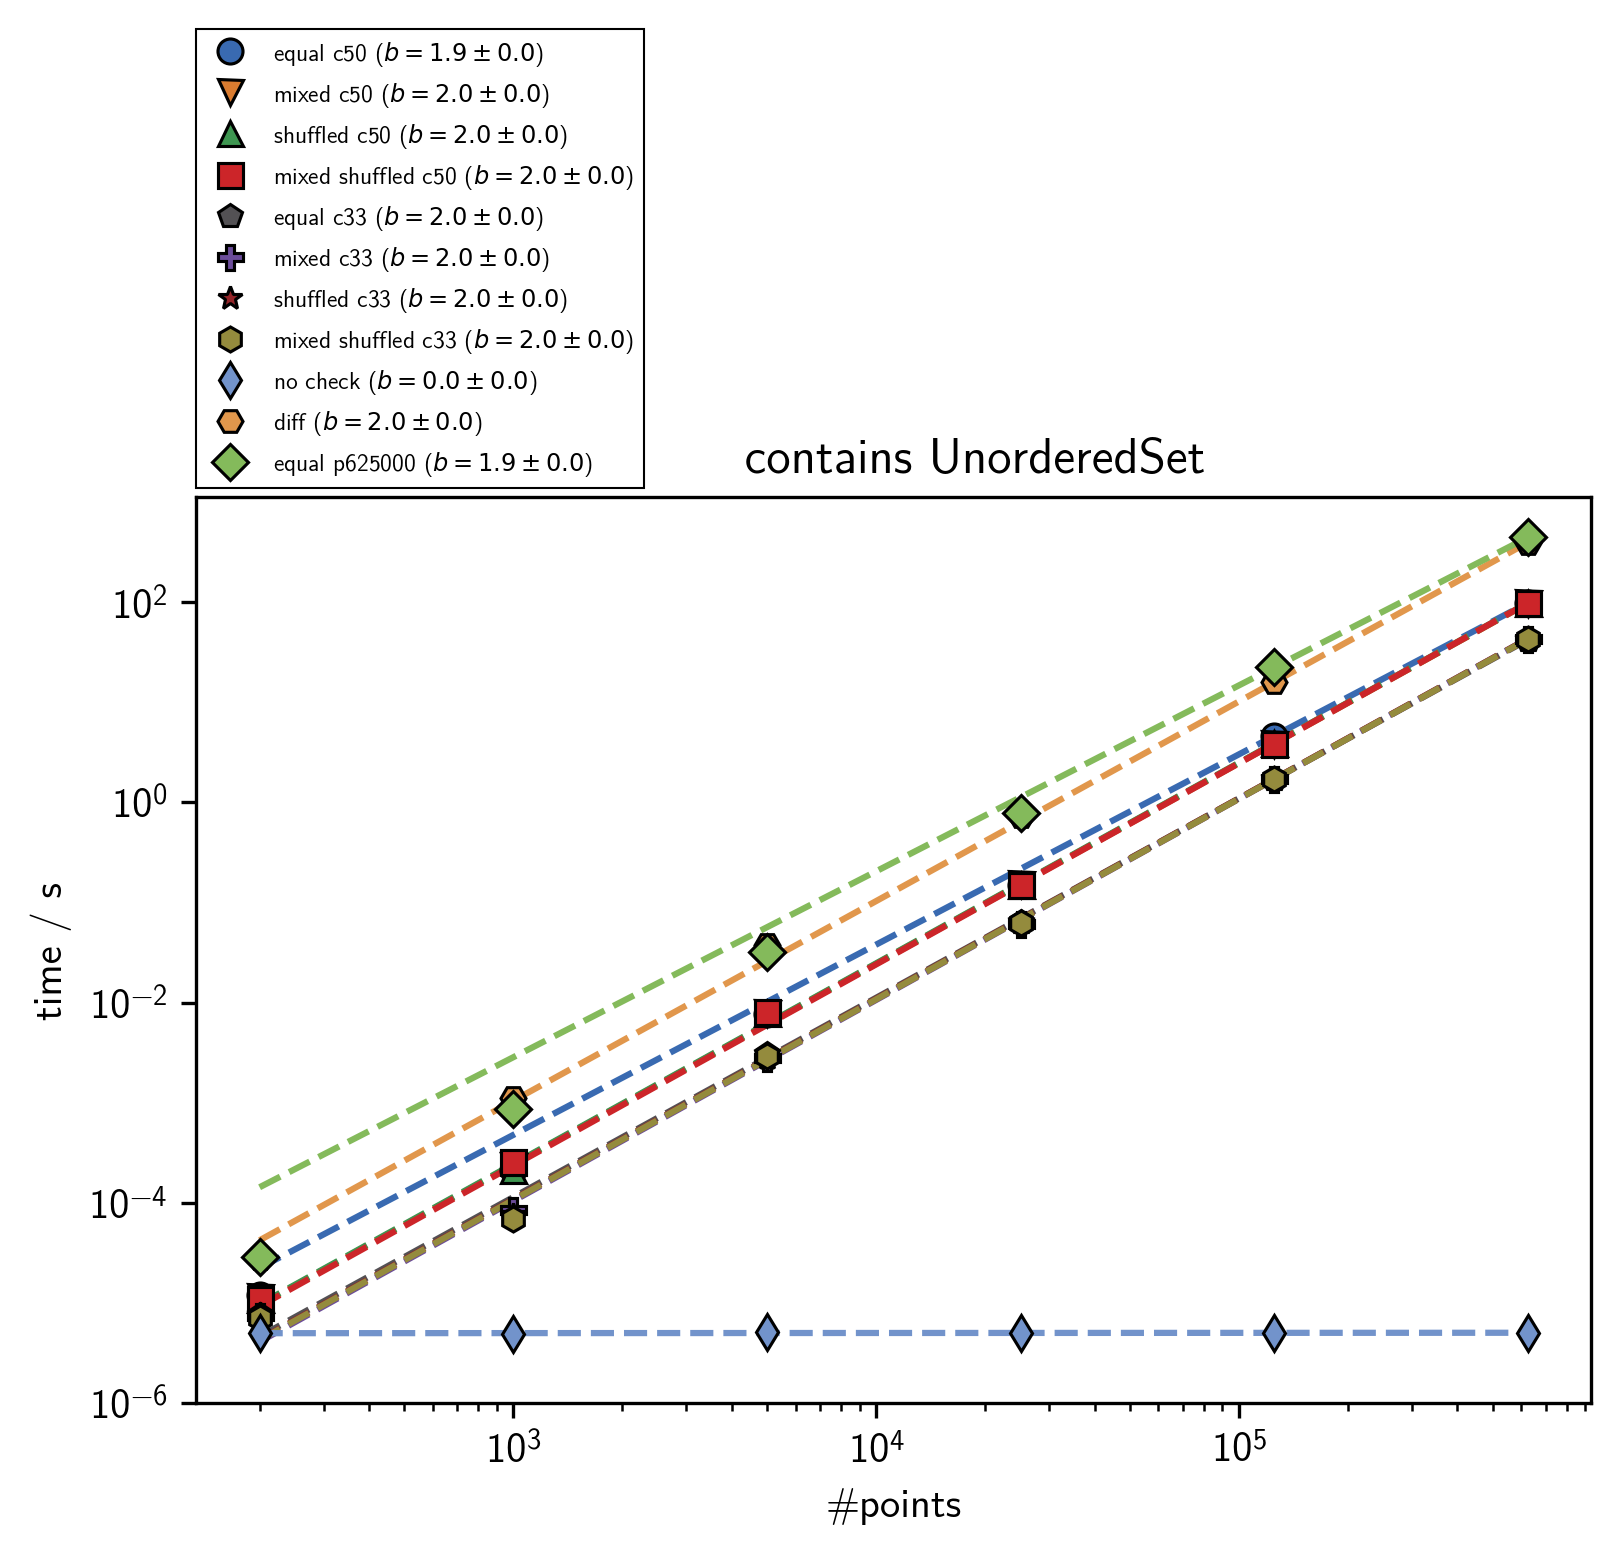

In [235]:
plt.close("all")
fig, log_ax = plt.subplots()
log_ax.set_prop_cycle(
    marker=marker_list,
    color=color_list,
)
_ = evaluate_timings(
    RUN_TIMINGS_MAP, RUN_SCALING_MAP, run_name_list,
    log_ax=log_ax,
    plot_props={
        "linestyle": "",
        "markeredgecolor": "k",
        "markeredgewidth": 0.75,
        },
    legend_props={
        "loc": (0, 1.01)
        }
    )

log_ax.set_title(" " * 10 + "Contains UnorderedSet")
log_ax.set_xlabel("#points")
log_ax.set_ylabel("time / s")

### Run a c

In [236]:
run_name_list = [
    (k, k.replace("_run_a_c", "").replace("_", " "))
    for k in RUN_TIMINGS_MAP.keys()
    if "run_a_c" in k
]

Text(0, 0.5, 'time / s')

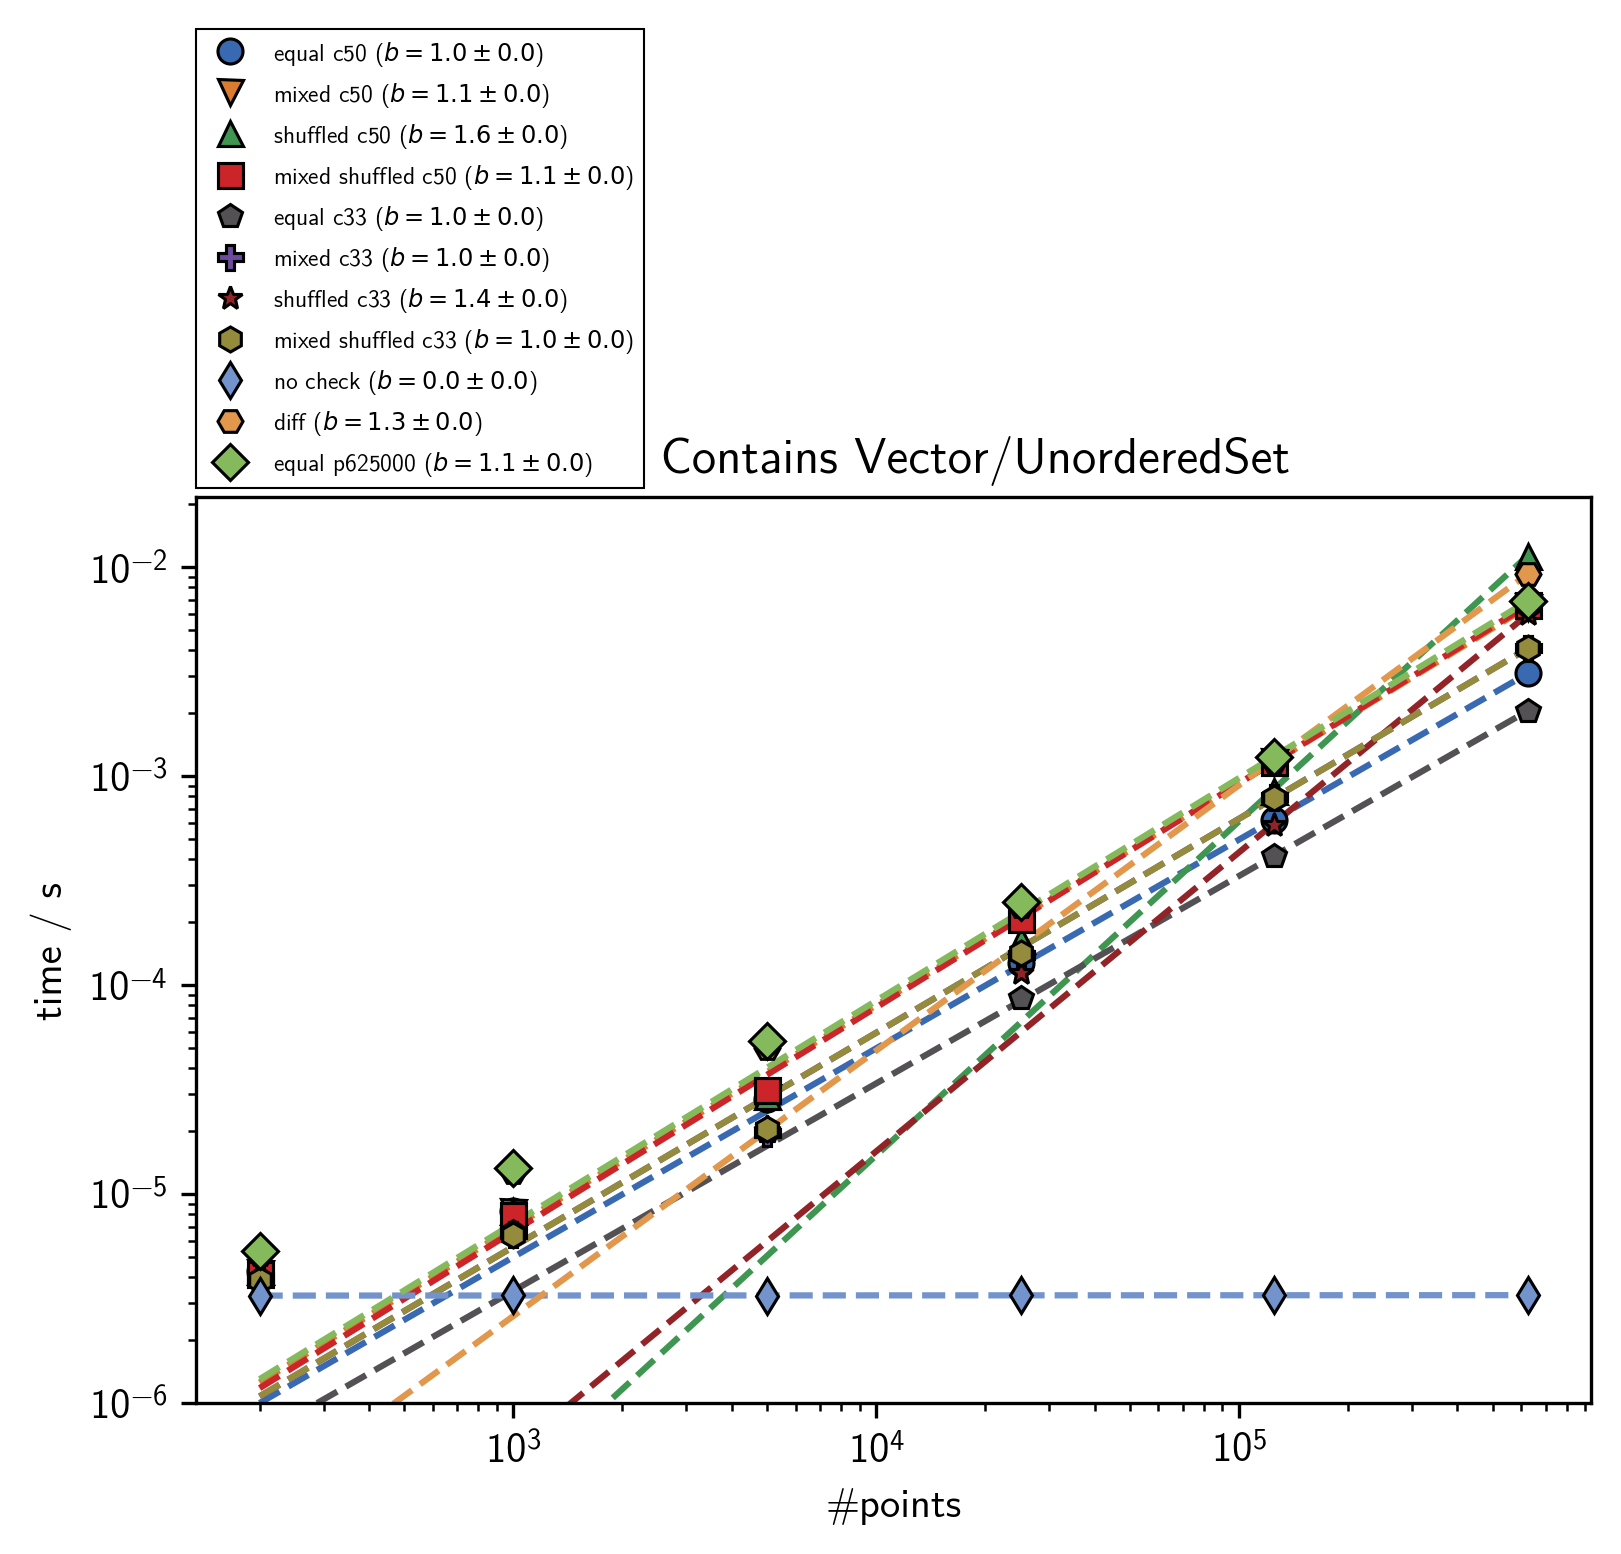

In [237]:
plt.close("all")
fig, log_ax = plt.subplots()
log_ax.set_prop_cycle(
    marker=marker_list,
    color=color_list,
)
_ = evaluate_timings(
    RUN_TIMINGS_MAP, RUN_SCALING_MAP, run_name_list,
    log_ax=log_ax,
    plot_props={
        "linestyle": "",
        "markeredgecolor": "k",
        "markeredgewidth": 0.75,
        },
    legend_props={
        "loc": (0, 1.01)
        }
    )

log_ax.set_title(" " * 10 + "Contains Vector/UnorderedSet")
log_ax.set_xlabel("#points")
log_ax.set_ylabel("time / s")

### Run b a

In [28]:
run_name_list = [
    (k, k.replace("_run_b_a", "").replace("_", " "))
    for k in RUN_TIMINGS_MAP.keys()
    if "run_b_a" in k
]

Text(0, 0.5, 'time / s')

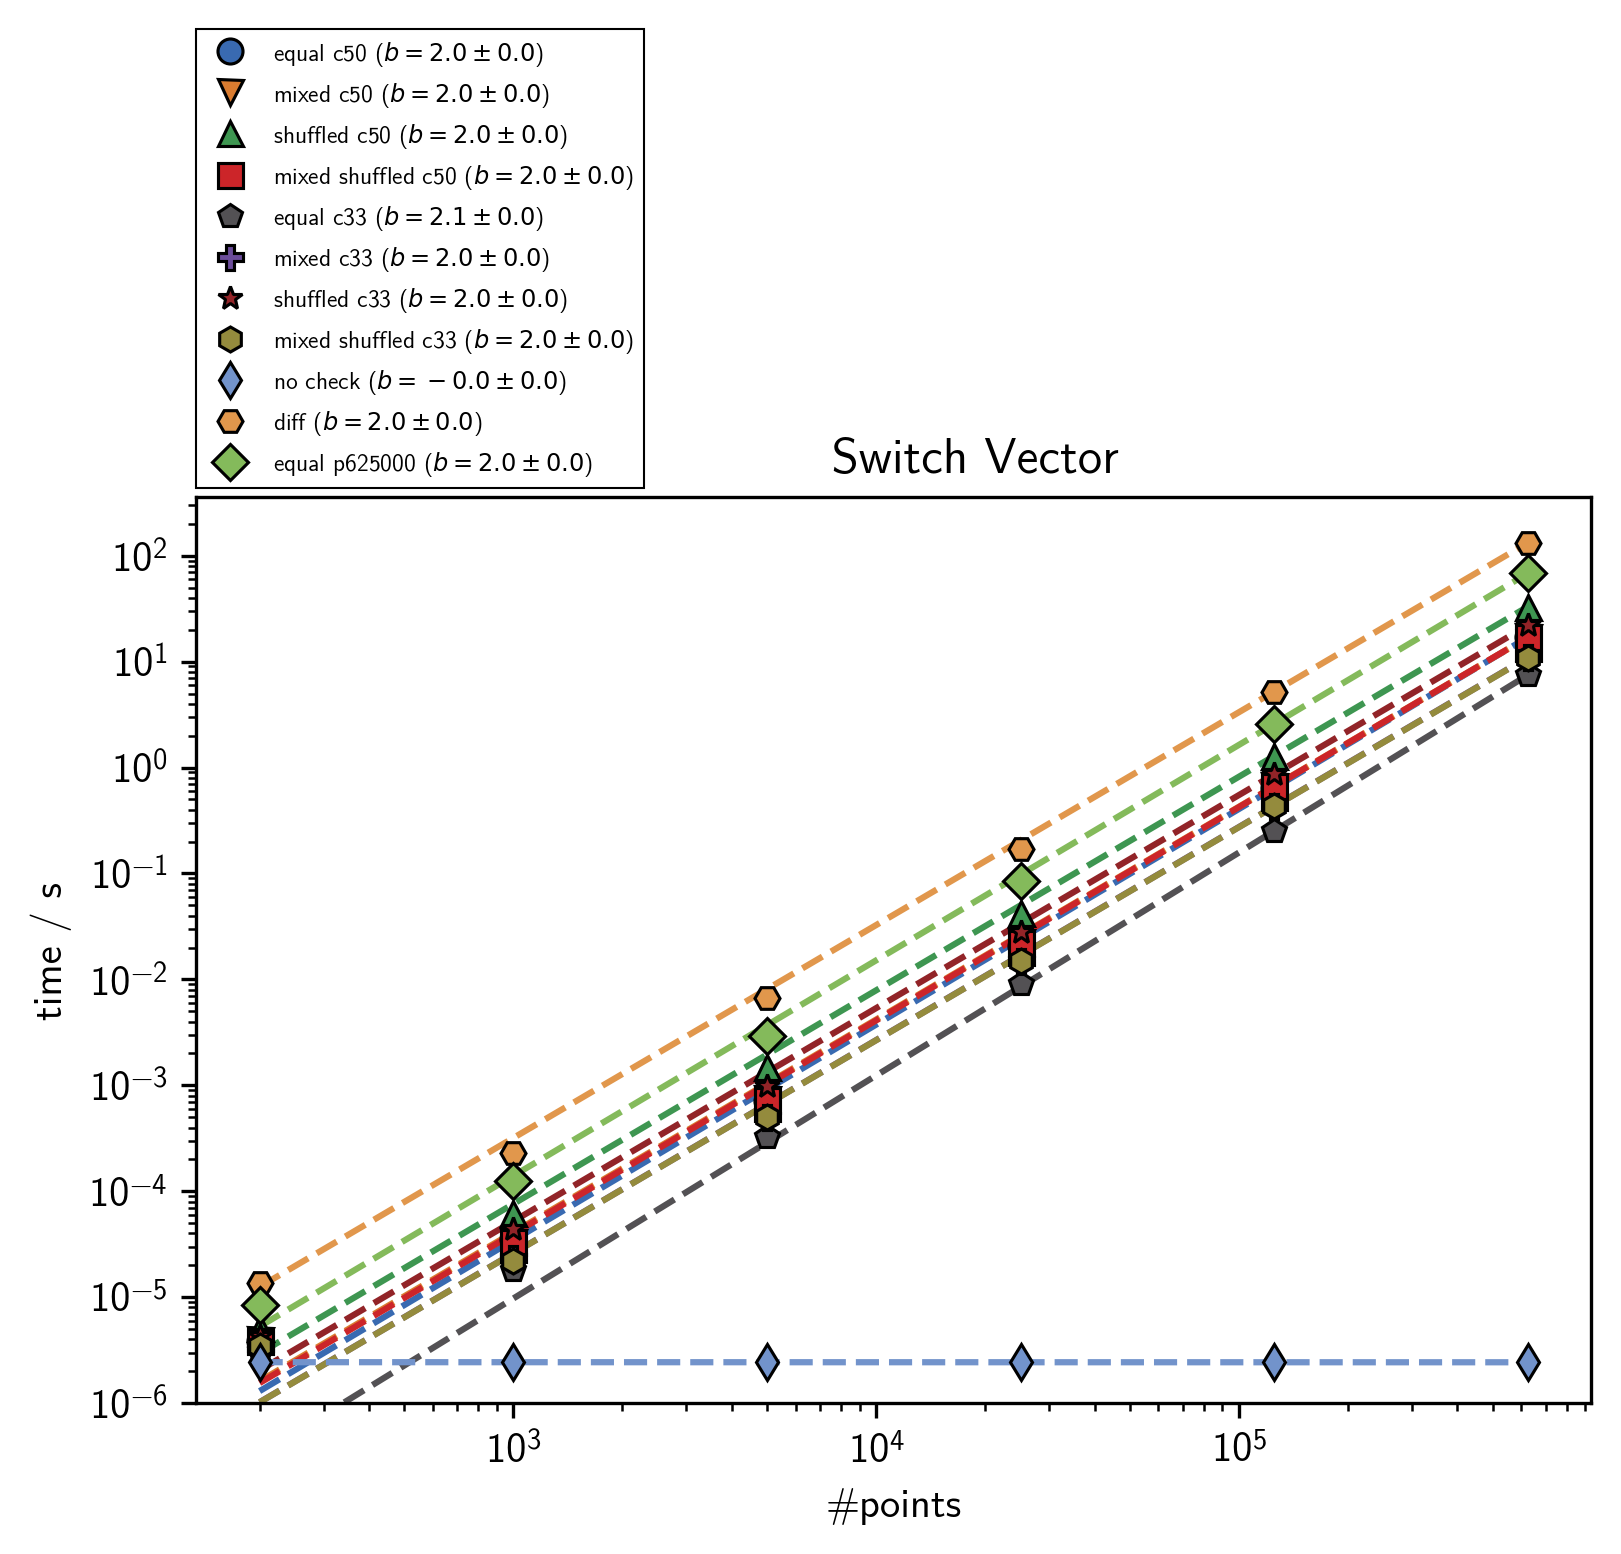

In [29]:
plt.close("all")
fig, log_ax = plt.subplots()
log_ax.set_prop_cycle(
    marker=marker_list,
    color=color_list,
)
_ = evaluate_timings(
    RUN_TIMINGS_MAP, RUN_SCALING_MAP, run_name_list,
    log_ax=log_ax,
    plot_props={
        "linestyle": "",
        "markeredgecolor": "k",
        "markeredgewidth": 0.75,
        },
    legend_props={
        "loc": (0, 1.01)
        }
    )

log_ax.set_title(" " * 10 + "Switch Vector")
log_ax.set_xlabel("#points")
log_ax.set_ylabel("time / s")

### Compare switch/no switch

In [248]:
run_name_list = [
    ("mixed_c50_run_a_a", "Contains (Vector)"),
    # ("mixed_c50_run_a_b", "Contains (Un.Set)"),
    ("mixed_c50_run_a_c", "Contains (Vector/Un.Set)"),
    ("mixed_c50_run_b_a", "Switch (Vector)"),
    ("mixed_c50_run_b_c", "Switch (Vector/Un.Set)"),
]

Text(0, 0.5, 'time / s')

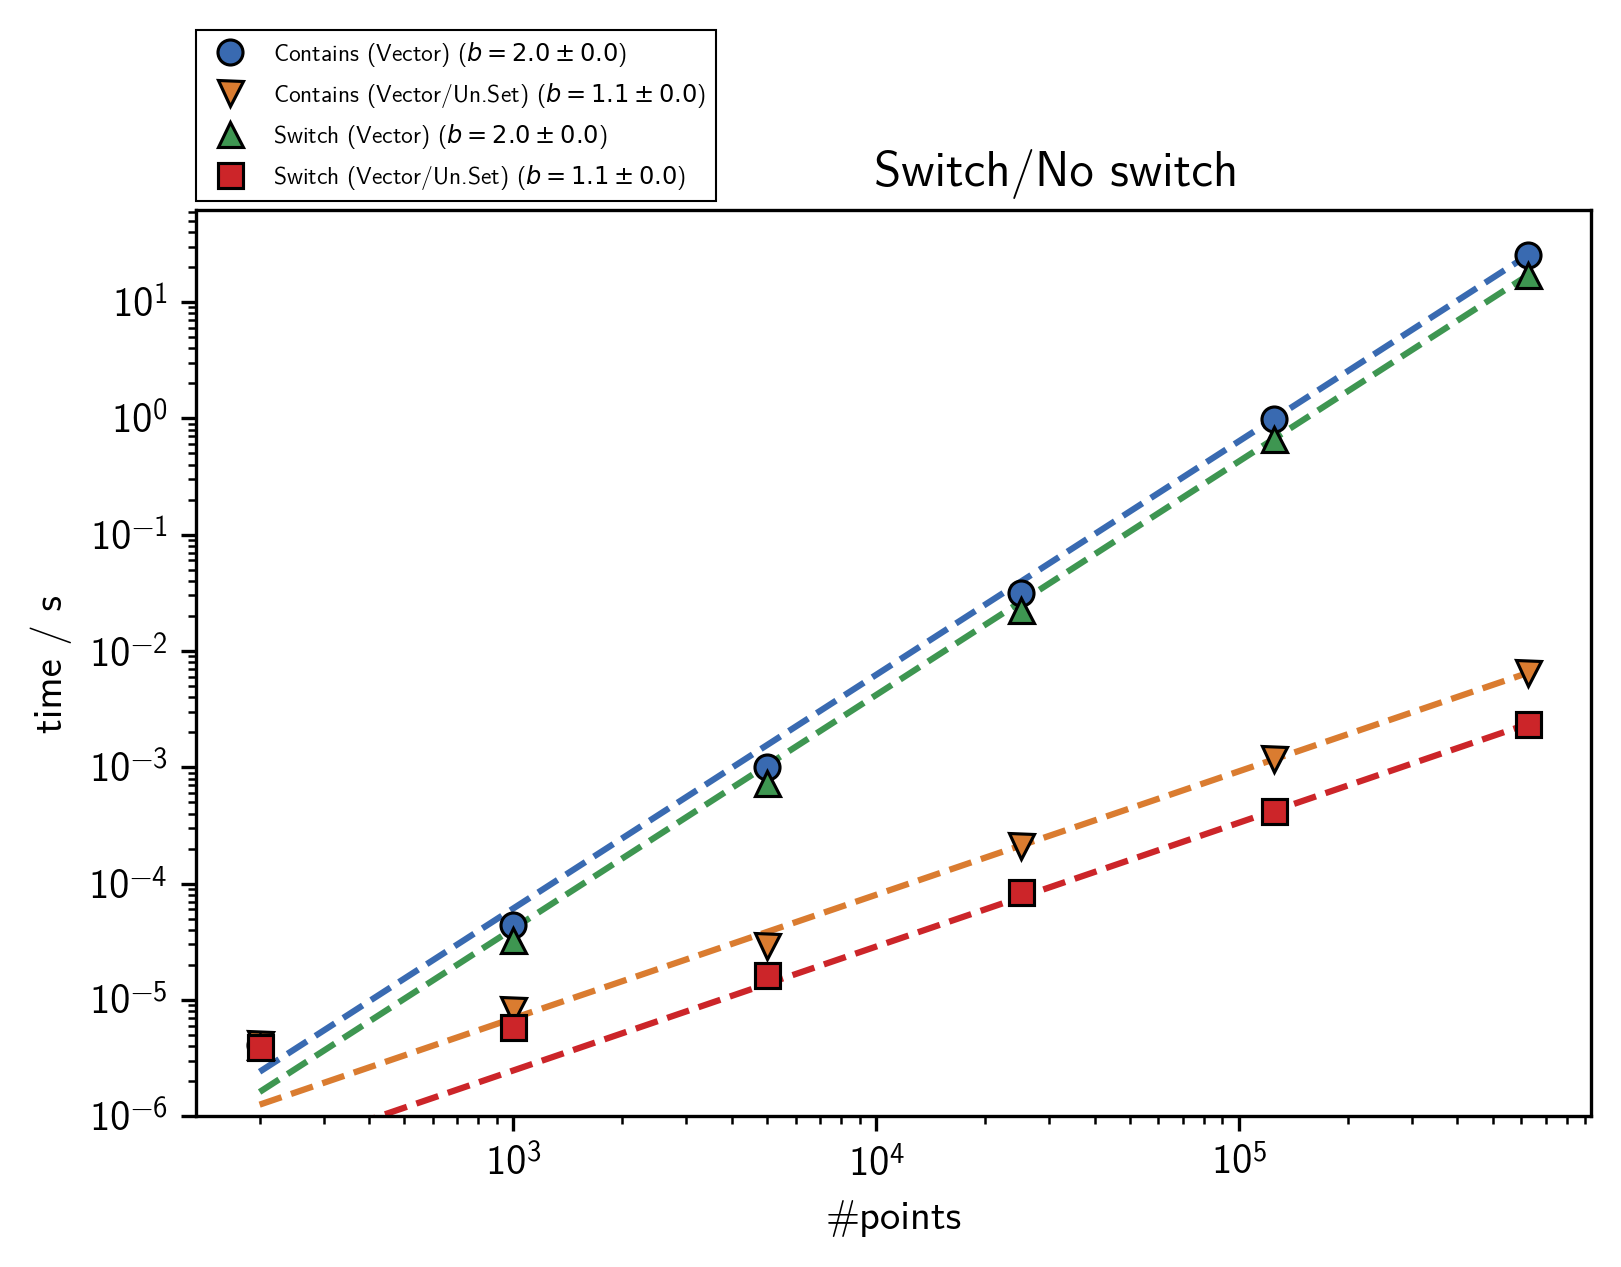

In [249]:
plt.close("all")
fig, log_ax = plt.subplots()
log_ax.set_prop_cycle(
    marker=marker_list,
    color=color_list,
)
_ = evaluate_timings(
    RUN_TIMINGS_MAP, RUN_SCALING_MAP, run_name_list,
    log_ax=log_ax,
    plot_props={
        "linestyle": "",
        "markeredgecolor": "k",
        "markeredgewidth": 0.75,
        },
    legend_props={
        "loc": (0, 1.01)
        }
    )

log_ax.set_title(" " * 20 + "Switch/No switch")
log_ax.set_xlabel("#points")
log_ax.set_ylabel("time / s")

### Compare worst case

In [ ]:
run_name_list = [
    ("diff_run_a_a", "Contains (Vector)"),
    ("diff_run_a_c", "Contains (Vector/Un.Set)"),
    ("diff_run_b_a", "Switch (Vector)"),
    ("diff_run_b_c", "Switch (Vector/Un.Set)"),
    ("diff_run_c_a", "Screen (Vector)"),
    ("diff_run_c_b", "Screen (Vector/Un.Set)"),
]

In [ ]:
plt.close("all")
fig, log_ax = plt.subplots()
log_ax.set_prop_cycle(
    marker=marker_list,
    color=color_list,
)
_ = evaluate_timings(
    RUN_TIMINGS_MAP, RUN_SCALING_MAP, run_name_list,
    log_ax=log_ax,
    plot_props={
        "linestyle": "",
        "markeredgecolor": "k",
        "markeredgewidth": 0.75,
        },
    legend_props={
        "loc": (0, 1.01)
        }
    )

log_ax.set_title(" " * 20 + "Worst case")
log_ax.set_xlabel("#points")
log_ax.set_ylabel("time / s")